# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Импорты и констансы

In [12]:
import os
import warnings
import time
from tqdm import tqdm
from tqdm import notebook
tqdm.pandas()


from PIL import Image
from pathlib import Path


import math
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, log_loss, f1_score, mean_squared_error

from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, RepeatVector, LSTM, Dropout
from tensorflow.keras.optimizers import Adam



In [2]:
PATH = '/Users/vs/Programming/Data Science/Data-Science-Projects/18. new/df'

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [4]:
train_data = pd.read_csv(os.path.join(PATH, 'train_dataset.csv'))
train_data.name = 'train_data'
data_crowd = pd.read_csv(os.path.join(PATH, 'CrowdAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'fraction', 'pros', 'cons'])
data_crowd.name = 'data_crowd'
data_expert = pd.read_csv(os.path.join(PATH, 'ExpertAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'first', 'second', 'third'])
data_expert.name = 'data_expert'
test_query = pd.read_csv(os.path.join(PATH, 'test_queries.csv'), index_col=[0], sep='|')
test_query.name = 'test_query'
test_image = pd.read_csv(os.path.join(PATH, 'test_images.csv'))
test_image.name = 'test_image'

In [6]:
for dataframe in [train_data, data_crowd, data_expert, test_query, test_image]:
    print('------------------------------------------------------------------------------------------------------------')
    print('+-------------+')
    print(f'| {dataframe.name}  |')
    print('+-------------+')
    display(dataframe.sample(5))
    print()

------------------------------------------------------------------------------------------------------------
+-------------+
| train_data  |
+-------------+


,image,query_id,query_text
2378,3364151356_eecd07a23e.jpg,500446858_125702b296.jpg#2,A white dog is running on gravel away from two...
431,541063517_35044c554a.jpg,2077079696_03380d218b.jpg#2,A man is hiking on a mountaintop on a cloudy d...
4708,2358561039_e215a8d6cd.jpg,3006093003_c211737232.jpg#2,The man in glasses carrying an Obama poster is...
4559,416788726_5b4eb1466e.jpg,3554634863_5f6f616639.jpg#2,A musician and a crowd next to stage full of m...
3435,491405109_798222cfd0.jpg,2860872588_f2c7b30e1a.jpg#2,Two dogs are jumping up at each other .



------------------------------------------------------------------------------------------------------------
+-------------+
| data_crowd  |
+-------------+


,image,query_id,fraction,pros,cons
5166,1998457059_c9ac9a1e1a.jpg,3168123064_d1983b8f92.jpg#2,0.0,0,3
34533,3467219837_7d62213dec.jpg,2696866120_254a0345bc.jpg#2,0.0,0,3
24348,309687244_4bdf3b591f.jpg,2902269566_419d9f1d8e.jpg#2,0.0,0,3
24590,3108197858_441ff38565.jpg,3453259666_9ecaa8bb4b.jpg#2,0.0,0,3
22748,3019842612_8501c1791e.jpg,670609997_5c7fdb3f0b.jpg#2,0.0,0,3



------------------------------------------------------------------------------------------------------------
+-------------+
| data_expert  |
+-------------+


,image,query_id,first,second,third
2830,3044536048_e615466e7f.jpg,2421446839_fe7d46c177.jpg#2,1,1,1
3880,3360930596_1e75164ce6.jpg,241345905_5826a72da1.jpg#2,1,2,3
2686,2991575785_bd4868e215.jpg,3353036763_4cbeba03b2.jpg#2,1,1,1
2369,2877503811_4e311253ec.jpg,2985679744_75a7102aab.jpg#2,2,2,3
5810,979383193_0a542a059d.jpg,3244747165_17028936e0.jpg#2,2,2,2



------------------------------------------------------------------------------------------------------------
+-------------+
| test_query  |
+-------------+


,query_id,query_text,image
287,3287969199_08e775d896.jpg#2,A gray bird is flying over the water .,3287969199_08e775d896.jpg
187,2977379863_2e8d7a104e.jpg#2,A girl in a cape along with other costumed chi...,2977379863_2e8d7a104e.jpg
53,1991806812_065f747689.jpg#3,Two boxers are in the ring .,1991806812_065f747689.jpg
319,3396275223_ee080df8b5.jpg#4,Three people are doing ballet exercises in ext...,3396275223_ee080df8b5.jpg
180,2887171449_f54a2b9f39.jpg#0,A woman sitting at a sewing machine looks up .,2887171449_f54a2b9f39.jpg



------------------------------------------------------------------------------------------------------------
+-------------+
| test_image  |
+-------------+


,image
34,2597308074_acacc12e1b.jpg
70,1580671272_3e99d94305.jpg
33,186346360_541047336f.jpg
98,2670637584_d96efb8afa.jpg
25,3722572342_6904d11d52.jpg


/var/folders/70/k39t_x2d08g08hls8fkylcyr0000gn/T/ipykernel_6483/3953532835.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
/var/folders/70/k39t_x2d08g08hls8fkylcyr0000gn/T/ipykernel_6483/3953532835.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


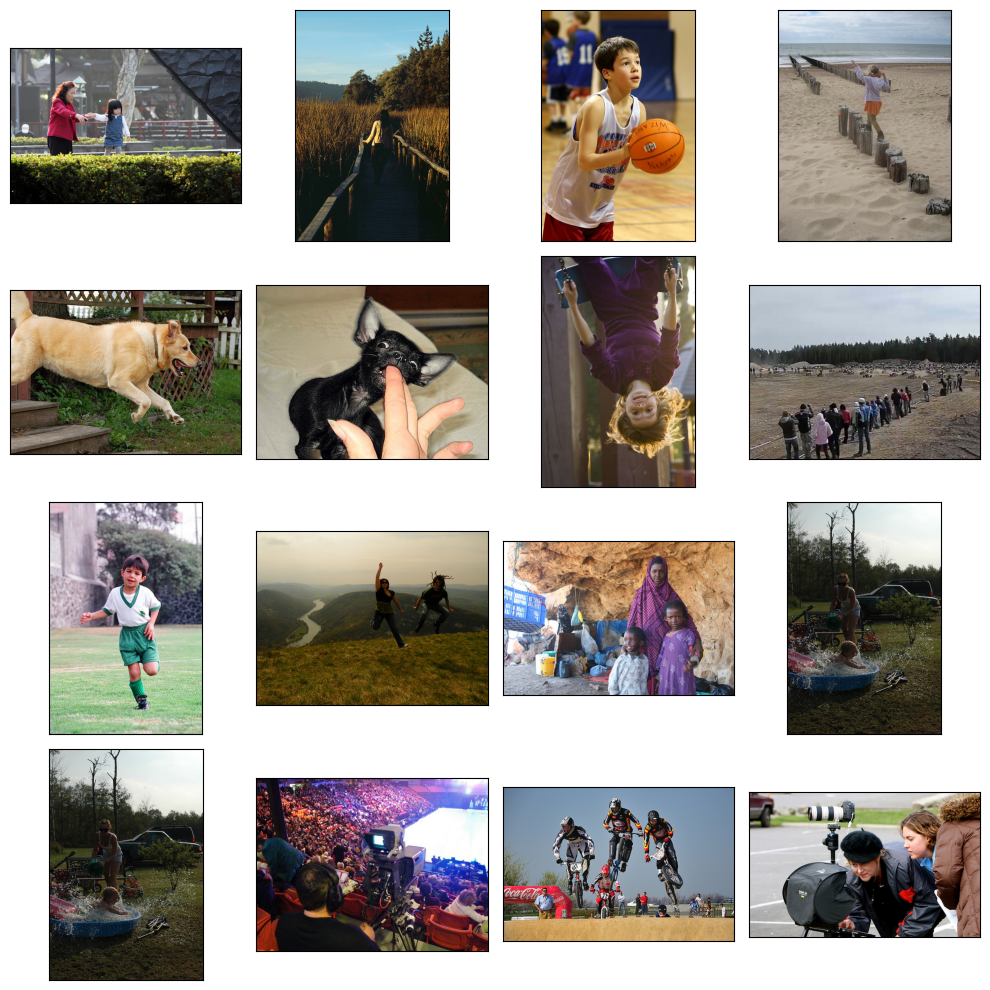

In [14]:
samples_train = list(train_data['image'].sample(8))
samples_test = list(test_query['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

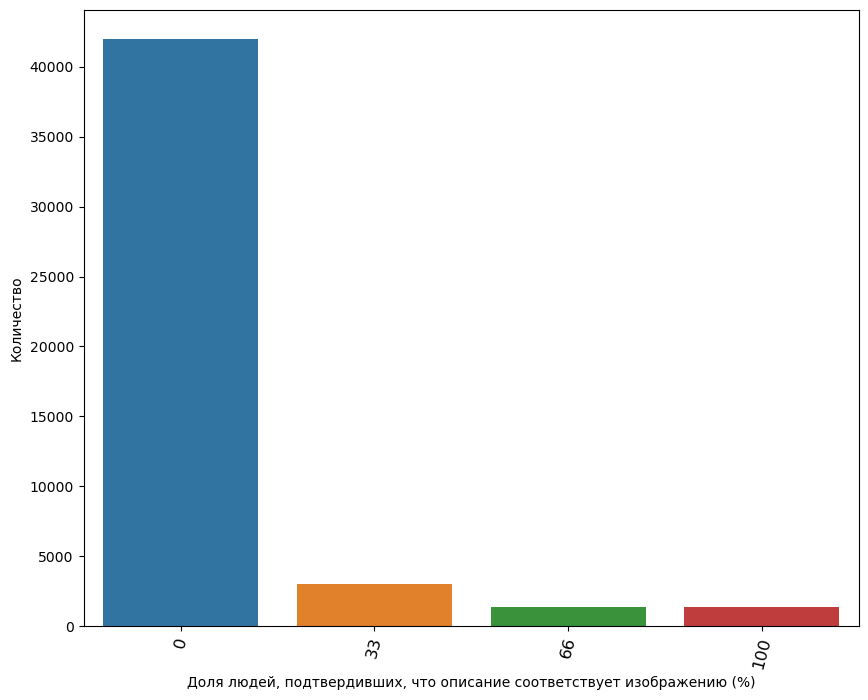

In [15]:
crowd_analicit = data_crowd.copy()
crowd_analicit['fraction'] *= 100
crowd_analicit['fraction'] = crowd_analicit['fraction'].astype('int')
crowd_array=[]
fraction_nums = np.array([0, 33, 66, 100])
for i in fraction_nums:
    crowd_array.append((crowd_analicit['fraction'] == i).sum())
    
plt.figure(figsize=(10, 8))
sns.barplot(x = fraction_nums, y = crowd_array)
plt.xticks(rotation=75, size=12)
plt.xlabel('Доля людей, подтвердивших, что описание соответствует изображению (%)')
plt.ylabel('Количество')
plt.show()

In [16]:
def agr_data(row):
    
    if row['first'] != row['second'] != row['third']:
        row['agr_expert'] = (row['first'] + row['second'] + row['third']) // 3
    else:
        row['agr_expert'] = int(np.median(row['first':'third']))
    
    return row
    
data_expert = data_expert.progress_apply(agr_data, axis=1)
data_expert

100%|██████████| 5822/5822 [00:01<00:00, 4573.72it/s]


,image,query_id,first,second,third,agr_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1
...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1


In [17]:
agr_expert_unique = data_expert.agr_expert.unique()
agr_expert_unique

array([1, 2, 3, 4])

In [18]:
data_merged = data_expert.merge(data_crowd, on = ['image', 'query_id'], how='outer')
data_merged

,image,query_id,first,second,third,agr_expert,fraction,pros,cons
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1.0,1.0,1.0,1.0,0.000000,0.0,3.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1.0,1.0,2.0,1.0,0.000000,0.0,3.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1.0,1.0,2.0,1.0,NaN,NaN,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1.0,2.0,2.0,2.0,NaN,NaN,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1.0,1.0,2.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
51318,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0
51319,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,NaN,NaN,NaN,NaN,0.333333,1.0,2.0
51320,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,NaN,NaN,NaN,NaN,1.000000,3.0,0.0
51321,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0


In [19]:
warnings.filterwarnings('ignore')

print('Количество NaN значений после объеденений массивов в agr_expert:', data_merged.isna().sum()[2])
print('Количество NaN значений после объеденений массивов в fraction:', data_merged.isna().sum()[3])
print()
print('Матрица корреляции agr_expert и fraction:')
display(data_merged[['agr_expert', 'fraction']].corr())

Количество NaN значений после объеденений массивов в agr_expert: 45501
Количество NaN значений после объеденений массивов в fraction: 45501

Матрица корреляции agr_expert и fraction:


,agr_expert,fraction
agr_expert,1.000000,0.762474
fraction,0.762474,1.000000


In [20]:
data_merged_notnan = data_merged.copy()
data_merged_notnan = data_merged_notnan.dropna()

for i in agr_expert_unique:
    print(f'Средняя доля людей, подтвердивших, что описание соответствует изображению (%) при оценке экспертов равной {i}:',
          '{:.0%}'.format(data_merged_notnan.loc[data_merged_notnan['agr_expert'] == i, 'fraction'].mean()),
          ', std:',
          '{:.0%}'.format(data_merged_notnan.loc[data_merged_notnan['agr_expert'] == i, 'fraction'].std()))
    
print()
print('Подсчёт уникальных значений столбца agr_expert')
print(data_merged_notnan.agr_expert.value_counts())
print()
print('Подсчёт уникальных значений столбца fraction')
print(data_merged_notnan.fraction.value_counts())

Средняя доля людей, подтвердивших, что описание соответствует изображению (%) при оценке экспертов равной 1: 0% , std: 3%
Средняя доля людей, подтвердивших, что описание соответствует изображению (%) при оценке экспертов равной 2: 5% , std: 14%
Средняя доля людей, подтвердивших, что описание соответствует изображению (%) при оценке экспертов равной 3: 31% , std: 32%
Средняя доля людей, подтвердивших, что описание соответствует изображению (%) при оценке экспертов равной 4: 89% , std: 20%

Подсчёт уникальных значений столбца agr_expert
agr_expert
2.0    957
1.0    604
3.0    463
4.0    305
Name: count, dtype: int64

Подсчёт уникальных значений столбца fraction
fraction
0.000000    1633
1.000000     263
0.333333     257
0.666667     158
0.250000       6
0.500000       4
0.200000       2
0.400000       2
0.800000       2
0.750000       2
Name: count, dtype: int64


In [22]:
def agr_merge(row):
    if row['fraction'] >= 0.75:
        return 4.0
    elif row['fraction'] >= 0.25:
        return 3.0
    elif row['fraction'] >= 0.10:
        return 2.0
    return 1.0

In [23]:
features_func = data_merged[['agr_expert', 'fraction']].copy()
features_func.dropna(inplace=True)
features_func['predict'] = features_func.apply(agr_merge, axis=1)

agr_expert_models = pd.DataFrame(columns = ['ACC'])

def alter_table(df, model_name, acc):
    '''Добавляет в нашу таблицу с анализом моделей данные'''
    
    agr_expert_models.loc[model_name, 'ACC'] = acc
    
    return df


alter_table(agr_expert_models,
            'BaseLine',
            round(accuracy_score(features_func['predict'], features_func['agr_expert']), 4))

,ACC
BaseLine,0.4538


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

## 8. Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска